# Assignment - 2: Data Representation and Point Cloud Operations

Team Name: Sentinels 

Roll number: 2019101054 2019111002

# Instructions

- Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
- Save all your results in ```results/<question_number>/<sub_topic_number>/```
- The **References** section provides you with important resources to solve the assignment.
- Make sure your code is modular since you may need to reuse parts for future assignments.
- Answer the descriptive questions in your own words with context & clarity. Do not copy answers from online resources or lecture notes.
- The **deadline** for this assignment is on 26/09/2021 at 11:55pm. Please note that there will be no extensions.
- Plagiarism is **strictly prohibited**.

# Submission Instructions

1. Make sure your code runs without any errors after reinitializing the kernel and removing all saved variables.
2. After completing your code and saving your results, zip the folder with name as ``Team_<team_name>_MR2021_Assignment_<assignment_number>.zip``

In [2]:
import numpy as np
import numpy.linalg as LA
import pandas as pd
from PIL import Image
import open3d as o3d
from IPython.display import display

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Introduction to types of Transformations and Homogeneous coordinates

In robotics applications, it is inevitable to keep track of the frames of multiple objects/worlds. These frames can be transformations from one coordinate frame to the other. **Homogeneous coordinates** help in keeping track of various coordinate frames and allow performing composition of various transforms. We will first try to understand between types of transformations and their invariant properties.
1. What is the difference between Affine, Similarity, and Euclidean transform? What are the invariant properities of each type of transform?
2. Watch this [video](https://www.youtube.com/watch?v=PvEl63t-opM) to briefly understand homogeneous coordinates. What are points at infinity? What type of transformation can you apply to transform a point from infinity to a point that is not at infinity? 
3. Using homogeneous coordinates we can represent different types of transformation as point transforms vs. frame transforms. Concatenation of transforms (whether you post multiply transformation matrices or pre-multiply transformation matrices) depends on the problem and how you are viewing it. Try to understand the difference between frame vs. point transformations from this [video](https://youtu.be/Za7Sdegf8m8?t=1834). Let's assume that our camera and world frames are coinciding with each other. We need to estimate the camera to world **frame** transformation matrix after applying the transformations defined below in terms of $T_i$.We apply **frame** transform to move the camera in the world in the following order:
    1. $T_1$ from the camera coordinate frame.
    2. $T_2$ from the world coordinate frame.
    3. $T_3$ from the world coordinate frame.
    4. $T_4$ from the camera coordinate frame.
    5. $T_5$ from the camera coordinate frame.


## Answer1. 
**Affine transformation** (linear transformation and translation) has 6 DOF in 2d (12 DOF {3 rotation 3 translation 3 scaling and 3 shear} in 3d) and its *invariant properties* are parallelism, the ratio of areas, the ratio of lengths on collinear or parallel lines (eg midpoints), a linear combination of vectors, and line at infinity.  
**Similarity transform** (rotation, translation, and scale) has 4 DOF  in 2d  (7 DOF {3 rotation 3 translation 1 scaling} in 3d).  
and its invariant properties include the ratio of lengths and angle and the isotropic scaling
**Euclidean transform** (rotation, translation, or reflection) has 3 DOF in 2d  (6 DOF {3 rotation  3 translation} in 3d) and invariant properties include length and area.  

Detailed Explanation (for 2D):  
**Affine transformations** are made up of a nonsingular linear transformation (rotation, scaling, etc ) plus a translation.  
    Properties:
    1. Origin does not necessarily match the origin.  
    It only stretches, reflects, rotates(for example diagonal matrix or orthogonal matrix), or shears(matrix with off-diagonal elements) a vector(the same applies to many vectors/a matrices).  
    2. Lines map to lines: We can see in the above transformation that the lines in the original pictures are still lines after the transformation, no bending.  
    3.Parallel lines  remain parallel after the transformation.  
    4.Ratios of lengths along lines preserved (midpoints preserved).  
    In general, an affine transformation is a composition of rotations, translations, dilations, and shears.While an affine transformation preserves proportions on lines, it does not necessarily preserve angles or lengths.  
    Any triangle can be transformed into any other by an affine transformation, so all triangles are affine and, in this sense, 
    affine is a generalization of congruent and similar.

**Similarity transform** is an isometry composed with an isotropic scaling.  
    Properties:  
    1. It preserves the shape  
    2. It has 4 degrees of freedom in 2d one for scaling, one for rotation, and two for translation  


**Euclidean transformations** preserve the invariant size of the figure, they change only the figure position in the space.  
Properties:  
    1. Euclidean transformations preserve the distance (length), the distance between the points on the figure (the process is called translation).  
    2. Euclidean transformations preserve angle measures. (ex. rotation of 180degrees with the center of rotation at the origin).  
    3. Euclidean transformations preserve betweenness, which means like c is a point between a and b the dist from a to c + dist from c to b = dist from a to b.  




## Answer 2.  
**Points at infinity**: By setting the last coordinate in homogeneous coordinate representation to zero we can express the 
points that are infinitely far away with finite coordinates. What it basically means is that the points in the form of [x, y, 0] in homogeneous coordinates are points at infinity. It is as if we divide the x and y with 0 if we want to go back to the Euclidean world, we get points infinitely far away, and also we still maintain the directions to the points. Even if the point is infinitely far away we can still estimate its direction.  


A point from infinity can be transformed to the point that is not at infinity with the help of projective transformation 
that has non-zero elements in the last row.  


## Answer 3  
Required transformation  is $(T_3 T_2 T_i T_1 T_4 T_5)^{-1}$ = $T_5^-1 * T_4^-1 * T_1^-1 * T_i^-1* T_2 ^-1 * T_3^-1$


# Visualise the Data

Point clouds are a collection of points that represent a 3D shape or feature. Each point has its own set of X, Y and Z coordinates and in some cases additional attributes. A popular way to obtain this is by photogrammetry, though here we will use LiDAR data.

LiDAR is a remote sensing process which collects measurements used to create 3D models and maps of objects and environments. Using ultraviolet, visible, or near-infrared light, LiDAR gauges spatial relationships and shapes by measuring the time it takes for signals to bounce off objects and return to the scanner.

1. Download the data from [here](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/venkata_surya_students_iiit_ac_in/EnYAMaTVIhJItzKYqtahE30BRKB6p6UfHN3TyJzvo6Mw0g?e=PegWds). It contains the LIDAR sensor output and odometry information per frame.

    The .bin files contain the 3D point cloud captured by the LIDAR in this format - x, y, z, and reflectance. 

    The odometry information is given in the `odometry.txt` file, which is a 12 element vector. Reshape each of the first 77 rows to a 3x4 matrix to obtain the pose.
    

2. Obtain the point cloud from this and visualise for 1-2 frames.

In [3]:
# reading and generating transformations for:  i_th cam frame to world frame

def generate_odo_T():
    with open("data/odometry.txt") as f:
        data = f.readlines()[:77]
    data = [list(map(float, line.split())) for line in data]
    odo= np.array(data).reshape(-1, 3,4)
    cam_to_world = []
    for rot_mat in odo:
        cam_to_world.append(np.vstack((rot_mat, [0,0,0,1])))
    return cam_to_world

odo_mat = generate_odo_T()

FileNotFoundError: [Errno 2] No such file or directory: 'data/odometry.txt'

In [3]:
# vizualizing some frames of LIDAR output
def get_lidar_frame(i, homo=False):
    bindata = np.fromfile("./data/LiDAR/" + str(i+10).zfill(6)+".bin",
                          dtype=np.float32)
    points_in_lidar = bindata.reshape(-1, 4)
    if homo:
        points_in_lidar[:, 3] = 1
        return points_in_lidar
    
    return points_in_lidar[:, :3]


for i in [10,33]:
    pcd = o3d.geometry.PointCloud(points= o3d.utility.Vector3dVector(
        get_lidar_frame(i, homo=False)
    )).voxel_down_sample(1)
    o3d.visualization.draw_geometries([pcd])


# Transform 

The point cloud obtained is with respect to the LiDAR frame. The poses however, are in the camera frame. If we want to combine the point clouds from various frames, we need to bring them to the camera frame. 

1. Refer to the image below and apply the required transformation to the point cloud. 

2. Then, register all point clouds into a common reference frame and visualise it (Open3D). It is helpful to use homogeneous coordinates to keep track of the different frames.

3. Write a function to transform the registered point cloud from the world to the $i^{th}$ camera frame, wherein $i$ is the input to the function.

4. \[Bonus\] Move around in the registered point cloud using arrow keys like you would do in a game. For this you will have to regularly transform the entire registered world to your current camera frame and visualize repeatedly. You may choose to avoid visualizing points that are behind the camera in this case as they are not visible from the scene. You may also visualize points at a max depth to make the process easier.

![](./img/transform.png)

In [4]:
#registering all points in one frame
all_points = None
T_lidar_to_cam = np.array(
    [[0, -1, 0, 0], [0, 0, -1, 0], [1, 0, 0, 0], [0, 0, 0, 1]
])
T_init_cam_to_world = np.array([
    [0, 0, 1, 0], [-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 0, 1]
])

for i in range(77):
    points_in_lidar = get_lidar_frame(i, homo=True)[::5]
    points_in_cam = points_in_lidar @ T_lidar_to_cam.T
    points_in_init_cam = points_in_cam @ odo_mat[i].T
    points_in_world = points_in_init_cam @ T_init_cam_to_world.T
    if all_points is None:
        all_points = points_in_world
    else:
        all_points = np.concatenate((all_points, points_in_world))

# vizualizing all points in one frame
pcd = o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector((all_points)[:, :3]))
print(len(pcd.points))
pcd = pcd.voxel_down_sample(2)
print(len(pcd.points))
o3d.visualization.draw_geometries([pcd])


1882721
8024


In [1]:
# function to convert pcd to i_th cam frame
def to_cam_frame(points, i:int)->o3d.geometry.PointCloud:
    points = points @ T_init_cam_to_world
    points = points @ odo_mat[i]
    return o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(
        points[:, :3]
    )).voxel_down_sample(2)


# vizualizing merged point cloud in a camera frame
newpcd = to_cam_frame(all_points, 2)
o3d.visualization.draw_geometries([newpcd])


NameError: name 'o3d' is not defined

## Bonus
move around the point cloud using the WASD keys in open3d scene vizualizer.

In [6]:
def get_key_callbacks():
    def move(vis, tr=[20, 0, 0]):
        
        ctr = vis.get_view_control()
        ctr.translate(tr[0], tr[1])
        return False

    return {
        ord("U"): lambda vis: move(vis, [0, 0, 15]),
        ord("I"): lambda vis: move(vis, [0, 0, -15]),
        ord("A"): lambda vis: move(vis, [-15, 0, 0]),
        ord("D"): lambda vis: move(vis, [15, 0, 0]),
        ord("W"): lambda vis: move(vis, [0, -15, 0]),
        ord("S"): lambda vis: move(vis, [0, 15, 0]),
    }


o3d.visualization.draw_geometries_with_key_callbacks(
    [pcd], get_key_callbacks())


# Occupancy Map

Occupancy grid maps are discrete fine grain grid maps. These maps can be either 2-D or 3-D. Each cell in the occupancy grid map contains information on the physical objects present in the corresponding space. Since these maps shed light on what parts of the environment are occupied, and what is not, they are really useful for path planning and navigation.

Occupancy grid maps are probabilistic in nature due to noisy measurements. Each cell can have three states: Occupied, unoccupied, and unknown. For the purpose of this assignment, you can ignore the unknown and work in a binary setting where 1 is occupied and 0 is unoccupied.

1. The task here is to create an occupancy map for each LiDAR scan. You do not need to apply bayesian update rules here, just keep it simple. 

2. Now, using the *registered* point cloud, generate occupancy maps for each frame. What difference do you expect to see between the two methods?

You can mark a cell as occupied based on a threshold of how many different z values are there for a particular (x,y) cell.

In [7]:
def coords_to_ocMap(points, threshold = 1):
    points = points[:, :3]      #if homo, now not
    points = np.array(points, dtype=np.int)
    df = pd.DataFrame(points, columns=['x','y','z']).drop_duplicates()
    # print(df.describe())
    df = df.groupby(["x","y"]).count()
    # print(df.head())
    # print(df.describe())
    xy_coords = np.array([*df.index.values]) + 200
    z_counts = np.array(df['z'])
    
    occMap  = np.zeros((400,400), dtype=np.uint8)
    for (x,y), zcnt in zip(xy_coords, z_counts):
        occMap[x][y] = 255 * int(zcnt > threshold)
    return occMap

def save_oc_map(ocmap, save_path:str):
    Image.fromarray(ocmap, 'L').save(save_path)
   
def display_ocmap(occMap, r = None):
    # plt.imshow(occMap, "gray")
    display(Image.fromarray(occMap, 'L'))



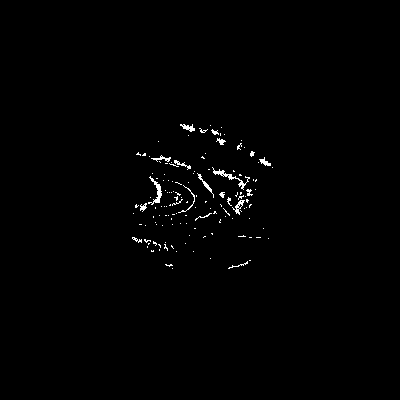

In [8]:
# displaying an frame
oc_map = coords_to_ocMap(get_lidar_frame(0))
display_ocmap(oc_map)

In [11]:
# saving all individual lidar scans as occ map
# in results/XXXXXX.png
for i in range(77):
    oc_map = coords_to_ocMap(get_lidar_frame(i))
    save_oc_map(oc_map, "results/" + str(i).zfill(6) + ".png")

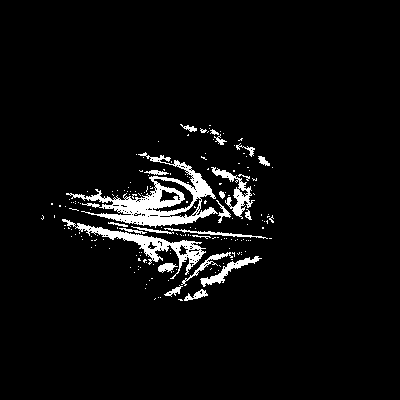

In [10]:
# occ map for all frames in one
# using all_points calculated in previous question 
oc_map = coords_to_ocMap(all_points[:, :3])
display_ocmap(oc_map)
save_oc_map(oc_map, "results/combined.png")